In [1]:
noExt=function(x){
return(tools::file_path_sans_ext(x))
}
bnoExt=function(x){
return(basename(tools::file_path_sans_ext(x)))
}
fNumber=function(x){
sapply(x,FUN=function(x){
strsplit(x,"__")[[1]][2]
})
}
rRider=function(x){
sapply(x,FUN=function(x){
strsplit(x,"-RIDER")[[1]][1]
})
}
# centering with 'scale()'
center_scale <- function(x) {
    scale(x, scale = FALSE)
}
#LOAD LIBRARIES 
library(gtools);
library("GenomicRanges");
options(warn=-1)
library(ggplot2)
get_entry_size <- function(entry) {
  return(entry$ChrEnd - entry$ChrStart)
}


Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb



In [2]:
#SETTING PATH 
pathAtacSeq="/sharedFolder/Data/6_Atacseq/"
results="/sharedFolder/Results/SequencingV2/Atacseq/"
previousResults="/sharedFolder/Results/Hotspot/"
pathcutTagMet="/sharedFolder/Data/6_Atacseq/"

In [5]:
gtf=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
gtf=gtf[grep("Ligase",gtf[,6]),]
gtfEntry=get_entry_size(gtf)
gtf$ChrEnd = gtf$ChrEnd + gtfEntry
gtf$ChrStart = gtf$ChrStart - gtfEntry
a=list.files(pathAtacSeq,pattern=".bedgraph",recursive=TRUE)
uu=grep("sorted",a)
if(length(uu)!=0){
a=a[-uu]
    }
a=mixedsort(a)
a2=sapply(a,FUN=function(x){strsplit(x,".bedgraph")[[1]][1]})
AtacSeq_count=matrix(0,ncol=length(unique(gtf[,7])),nrow=length(a2))
colnames(AtacSeq_count)=sapply(unique(gtf[,7]),FUN=toString)
rownames(AtacSeq_count)=a2
AtacSeq_rpm=AtacSeq_count
for(j in a){
    system(paste("echo",j))
temp=read.table(paste(pathAtacSeq,"/",j,sep=""),sep="\t")
tempGG=GRanges(seqnames=as.matrix(temp[,1]),ranges=IRanges(start = as.numeric(temp[,2]),end=as.numeric(temp[,3])),mcols=abs(as.numeric(temp[,4])))
    for(i in seq(nrow(gtf))){
        system(paste("echo",i/nrow(gtf)))
        gg=GRanges(seqnames=as.matrix(gtf[i,1]),ranges=IRanges(start = as.numeric(gtf[i,2]),end=as.numeric(gtf[i,3])))    
        over=findOverlaps(gg,tempGG)@to    
        name=as.vector(noExt((j)))
        AtacSeq_count[name,toString(gtf[i,7])]= sum(tempGG[over]$mcols)
        AtacSeq_rpm[name,toString(gtf[i,7])]= (sum(tempGG[over]$mcols)/sum(abs(temp[,4])))*1000000

   }

}
write.table((t(AtacSeq_count)),paste(results,"/AtacSeq_AID_Heatmap_count.csv",sep=""),col.names=NA,sep=",")
write.table((t(AtacSeq_rpm)),paste(results,"/AtacSeq_AID_Heatmap_RPM.csv",sep=""),col.names=NA,sep=",")


In [3]:
results

[1] "/sharedFolder/Results/SequencingV2/Atacseq/"

[1] "RAW"
P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 5.068012e-27 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 2.67028e-15 


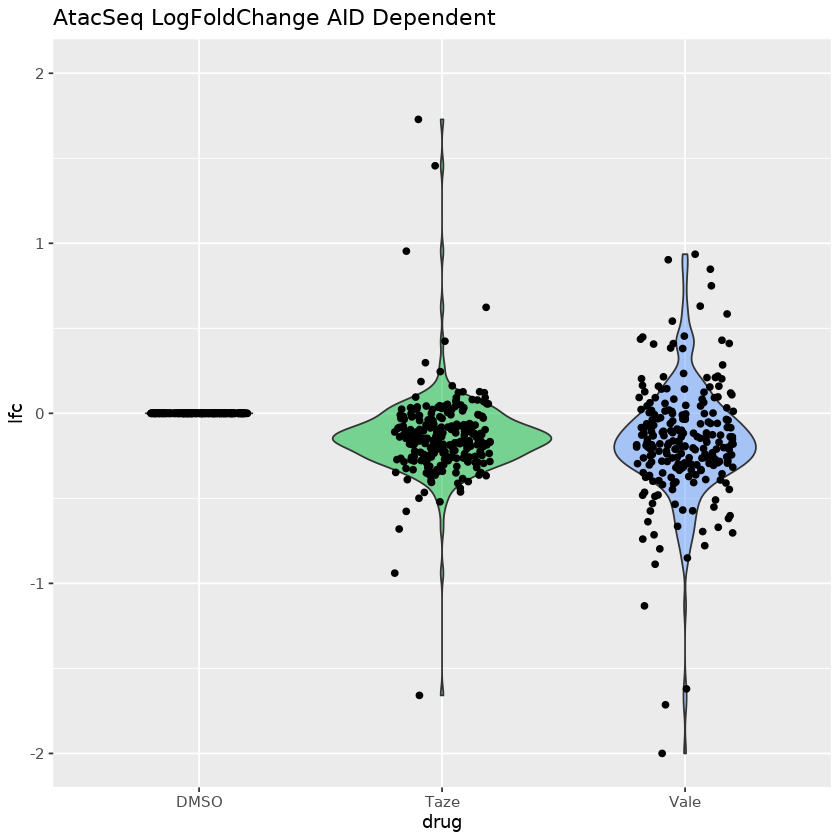

In [4]:
print("RAW")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/AtacSeq_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
data=log2(cutTagMet_newrpm+1)
filterVale=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/Lig_DMSOVale.csv",header=TRUE,row.names=1,sep=",")))
filterVale=unlist(sapply(filterVale,FUN=function(x){toString(x)}))

filterTaze=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/Lig_DMSOTaze.csv",header=TRUE,row.names=1,sep=",")))
filterTaze=unlist(sapply(filterTaze,FUN=function(x){toString(x)}))

foldChange=list()
geneWide=cutTagMet_newrpm+1 #0.000001


foldChange[[1]]=log2(geneWide[filterTaze,2]/geneWide[filterTaze,1])
foldChange[[2]]=log2(geneWide[filterVale,3]/geneWide[filterVale,1])


names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill=drug)) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2)) +
theme(legend.position = "none") + ylim(-2,2) + ggtitle("AtacSeq LogFoldChange AID Dependent")
plot(pp)   
condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")

[1] "RAW Common "
P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 4.669123e-16 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 4.131238e-10 


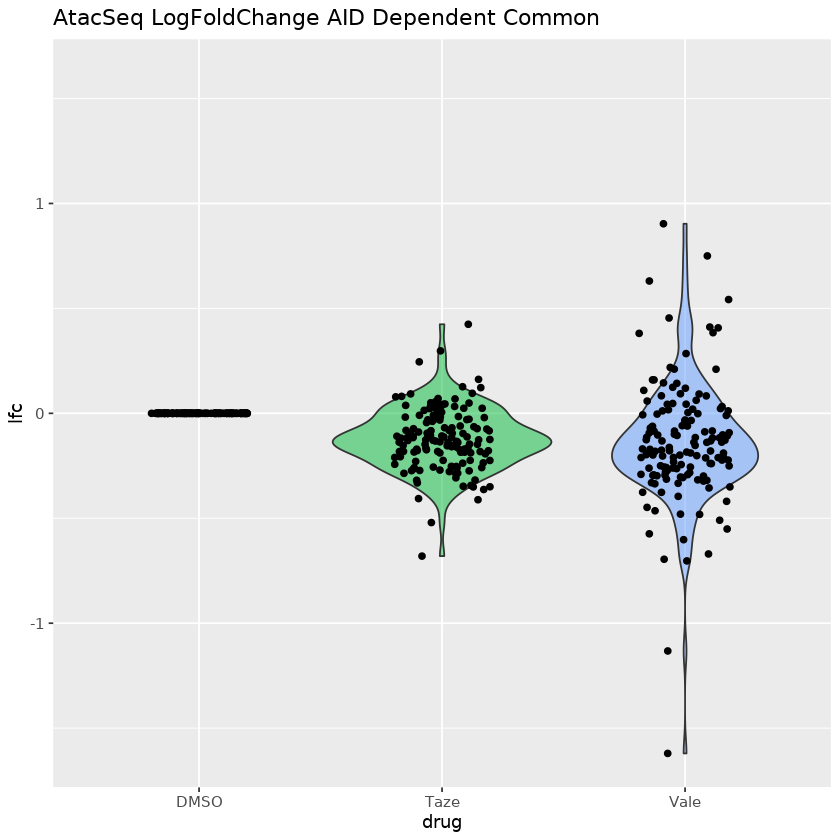

In [5]:
print("RAW Common ")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/AtacSeq_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
data=log2(cutTagMet_newrpm+1)

filterVale=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/sortNames/_5_DMSOVale.csv",header=TRUE,row.names=1,sep=",")))
filterVale=unlist(sapply(filterVale,FUN=function(x){toString(x)}))

filterTaze=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/sortNames/_2_DMSO_TAZE.csv",header=TRUE,row.names=1,sep=",")))
filterTaze=unlist(sapply(filterTaze,FUN=function(x){toString(x)}))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001


foldChange[[1]]=log2(geneWide[filterTaze,2]/geneWide[filterTaze,1])
foldChange[[2]]=log2(geneWide[filterVale,3]/geneWide[filterVale,1])


names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill=drug)) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2)) +
theme(legend.position = "none") + ylim(-lim,lim) + ggtitle("AtacSeq LogFoldChange AID Dependent Common")
plot(pp)   
condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")

[1] "filtered"
P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 2.563825e-05 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 3.582074e-05 


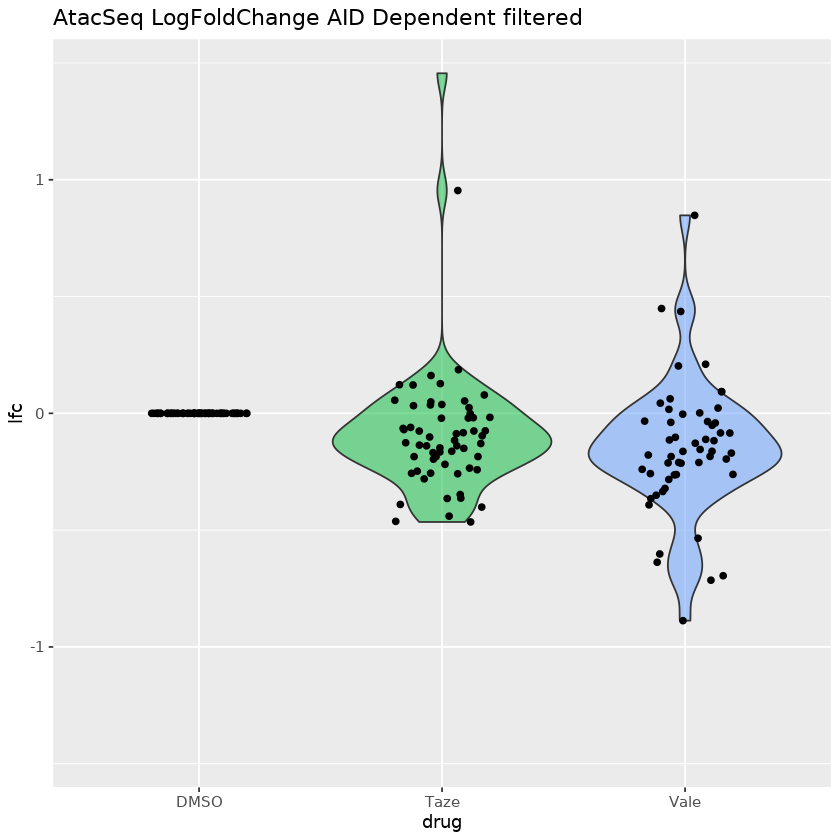

In [6]:
print("filtered")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/AtacSeq_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
data=log2(cutTagMet_newrpm+1)

filterVale=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/filtered_Lig_DMSOVale.csv",header=TRUE,row.names=1,sep=",")))
filterVale=unlist(sapply(filterVale,FUN=function(x){toString(x)}))

filterTaze=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/filtered_Lig_DMSOTaze.csv",header=TRUE,row.names=1,sep=",")))
filterTaze=unlist(sapply(filterTaze,FUN=function(x){toString(x)}))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001


foldChange[[1]]=log2(geneWide[filterTaze,2]/geneWide[filterTaze,1])
foldChange[[2]]=log2(geneWide[filterVale,3]/geneWide[filterVale,1])


names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill=drug)) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2)) +
theme(legend.position = "none") + ylim(-lim,lim) + ggtitle("AtacSeq LogFoldChange AID Dependent filtered")
plot(pp)   
condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")

[1] "filtered Common"
P-value for Taze Ligase4 KO vs DMSO Ligase4 KO is: 0.05222988 
P-value for Vale Ligase4 KO vs DMSO Ligase4 KO is: 0.0006498098 


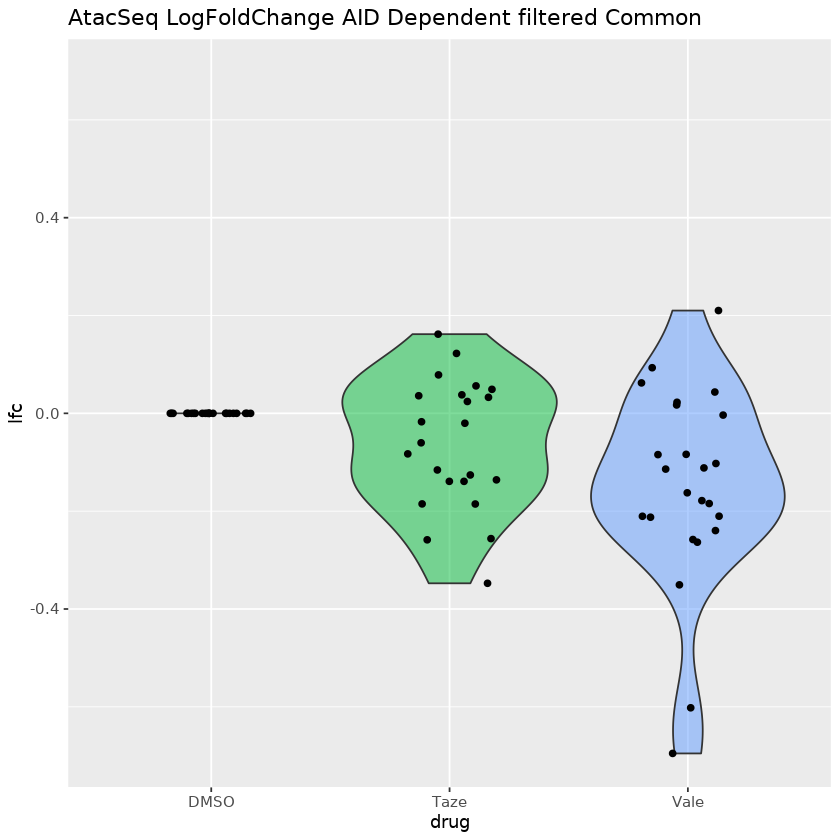

In [7]:
print("filtered Common")
Database=read.table(paste(previousResults,"Database.csv",sep="/"),header=TRUE,sep=",")
cutTagMet_newrpm=as.matrix(read.table(paste(results,"/AtacSeq_AID_Heatmap_count.csv",sep=""),header=TRUE,row.names=1,sep=","))
data=log2(cutTagMet_newrpm+1)

filterVale=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/sortNames/_5_DMSOVale.csv",header=TRUE,row.names=1,sep=",")))
filterVale=unlist(sapply(filterVale,FUN=function(x){toString(x)}))

filterTaze=unique(rownames(read.table("/sharedFolder/Results/Ligase4/rpmPlot/filtered/sortNames/_2_DMSO_TAZE.csv",header=TRUE,row.names=1,sep=",")))
filterTaze=unlist(sapply(filterTaze,FUN=function(x){toString(x)}))

foldChange=list()
geneWide=cutTagMet_newrpm+0.000001


foldChange[[1]]=log2(geneWide[filterTaze,2]/geneWide[filterTaze,1])
foldChange[[2]]=log2(geneWide[filterVale,3]/geneWide[filterVale,1])


names(foldChange)=c("Taze","Vale")

foldChangeDF=cbind(foldChange[[1]],rep("Taze",length(foldChange[[1]])))
foldChangeDF=rbind(foldChangeDF,cbind(foldChange[[2]],rep("Vale",length(foldChange[[2]]))))
foldChangeDF=rbind(foldChangeDF,cbind(0,rep("DMSO",length(foldChange[[1]]))))
lim=max(abs(foldChange[[1]]),abs(foldChange[[2]]))

colnames(foldChangeDF)=c("lfc","drug")
foldChangeDF=data.frame(foldChangeDF,check.names=FALSE,fix.empty.names=FALSE)
foldChangeDF$lfc=as.numeric(foldChangeDF$lfc)

pp=ggplot(foldChangeDF,aes(x=drug,y=lfc,fill=drug)) +
geom_violin(alpha = 0.5) +
geom_point(position = position_jitter(seed = 1, width = 0.2)) +
theme(legend.position = "none") + ylim(-lim,lim) + ggtitle("AtacSeq LogFoldChange AID Dependent filtered Common")
plot(pp)   
condition_of_interest1 = data[filterTaze,2]
condition_of_interest2 = data[filterVale,3]
reference_condition1 <- data[filterTaze,1]
reference_condition2 <- data[filterVale,1]

pvalueTAZE= wilcox.test(condition_of_interest1, reference_condition1,paired=TRUE)$p.value
pvalueVALE= wilcox.test(condition_of_interest2, reference_condition2,paired=TRUE)$p.value
  cat("P-value for","Taze Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueTAZE, "\n")
  cat("P-value for","Vale Ligase4 KO", "vs DMSO Ligase4 KO is:",pvalueVALE, "\n")

In [8]:
#RPM!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!